# Clustering the Beaded Helix Transtion from R- to L-Helix

## Import Libraries and Define CV Subroutines

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyemma
from shapeGMM import gmm_shapes
import MDAnalysis as md

In [2]:
import time
def weighted_cross_validate_cluster_scan(traj_data, n_train_frames, cluster_array = np.arange(2,9,1).astype(int), n_training_sets=10, n_attempts = 5):
    """
    perform cross validation weighted shape-GMM for range of cluster sizes
    Inputs:
        traj_data                  (required)  : float64 array with dimensions (n_frames, n_atoms,3) of molecular configurations
        n_train_frames             (required)  : int     scalar dictating number of frames to use as training (rest is used for CV)
        cluster_array       (default: [2..8])  : int     array of cluster sizes - can be of any number but must be ints. Default is [2, 3, 4, 5, 6, 7, 8]
        n_training_sets         (default: 10)  : int     scalar dictating how many training sets to choose. Default is 10
        n_attempts               (default: 5)  : int     scalar dictating how many attempts to perform shape-GMM on same set.  Default is 5
    Returns:
        weighted_train_log_lik                 : float64 array with dimensions (n_clusters, n_training_sets) containing log likelihoods for each training set
        weighted_predict_log_lik               : float64 array with dimensions (n_clusters, n_training_sets) containing log likelihoods on each CV set
    """
    # meta data from input array
    n_frames = traj_data.shape[0]
    # set parameters
    n_predict_frames = n_frames - n_train_frames
    print("Number of frames to train each model:", n_train_frames)
    print("Number of frames to predict each model:", n_predict_frames)
    print("Number of training sets:", n_training_sets)
    print("Number of clusters:", cluster_array.size)
    print("Number of attempts per set/cluster:", n_attempts)
    sys.stdout.flush()
    # open data files
    weighted_train_log_lik = np.empty((cluster_array.size,n_training_sets),dtype=np.float64)
    weighted_predict_log_lik = np.empty((cluster_array.size,n_training_sets),dtype=np.float64)
    # print log info
    print("%15s %15s %15s %19s %15s" % ("Training Set", "N Clusters", "Attempt", "Log Like per Frame","CPU Time (s)"))
    print("%84s" % ("------------------------------------------------------------------------------------"))
    # loop over training sets
    for training_set in range(n_training_sets):
        # shuffle trajectory data
        np.random.shuffle(traj_data)
        # create training and predict data
        train_data = traj_data[:n_train_frames]
        predict_data = traj_data[n_train_frames:]
        # loop over all number of clusters
        for cluster_index, cluster_size in enumerate(cluster_array):
            w_log_lik = []
            w_objs = []
            # for each n_clusters and training set, perform shape-GMM n_attempts times and take object with largest log likelihood
            for attempt in range(n_attempts):
                start_time = time.process_time()
                wsgmm = gmm_shapes.ShapeGMM(cluster_size,kabsch_thresh=1e-1,init_cluster_method='random',init_iter=5)
                wsgmm.fit_weighted(train_data)
                w_log_lik.append(wsgmm.log_likelihood)
                w_objs.append(wsgmm)
                elapsed_time = time.process_time()-start_time
                print("%15d %15d %15d %19.3f %15.3f" % (training_set+1, cluster_size, attempt+1, np.round(wsgmm.log_likelihood/wsgmm.n_frames,3), np.round(elapsed_time,3)))
            # determine maximum
            w_arg = np.argmax(w_log_lik)
            # save training log likes
            weighted_train_log_lik[cluster_index,training_set] = w_log_lik[w_arg]
            # save prediction log likes
            weighted_predict_log_lik[cluster_index,training_set] = w_objs[w_arg].predict_weighted(predict_data)[2]

    # convert to log likelihood per frame
    weighted_train_log_lik /= n_train_frames
    weighted_predict_log_lik /= n_predict_frames
    #return
    return weighted_train_log_lik, weighted_predict_log_lik

In [3]:
# reorder cluster numbers based on populations in descending order
def reorder_gmm_cluster_obj(sgmm_obj):
    # determine metadata based on clusters
    n_frames = sgmm_obj.n_frames
    cluster_ids, cluster_populations = np.unique(sgmm_obj.clusters,return_counts=True)
    n_clusters = cluster_ids.size
    print("Number of clusters:", n_clusters)
    print("Populations prior to reorder:", cluster_populations/n_frames)
    # determine sort key
    sort_key = np.argsort(cluster_populations)[::-1]
    sorted_cluster_ids = cluster_ids[sort_key]
    new_clusters = np.empty(n_frames,dtype=int)
    for frame in range(n_frames):
        new_clusters[frame] = np.argwhere(sorted_cluster_ids == sgmm_obj.clusters[frame])
    cluster_ids, cluster_populations = np.unique(new_clusters,return_counts=True)
    print("Populations after reorder:", cluster_populations/n_frames)
    # repopulate object
    sgmm_obj.precisions = sgmm_obj.precisions[sort_key]
    sgmm_obj.lpdets = sgmm_obj.lpdets[sort_key]
    sgmm_obj.centers = sgmm_obj.centers[sort_key]
    sgmm_obj.weights = sgmm_obj.weights[sort_key]
    sgmm_obj.ln_weights = sgmm_obj.ln_weights[sort_key]
    sgmm_obj.clusters = new_clusters

## Read trajectory

In [4]:
prmtopFileName = "helix_template.pdb"
trajFileName = "helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
trajData = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    trajData[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 10001
Number of atoms in selection: 12


## Perform Cross Validation Cluster Scan (can take a while)

In this scan, it is possible for divide by zero errors to arise.  This occurs when there are very few (maybe only 1) frame per cluster.  We have only observed this for very simple systems such as this beaded helix example. 

In [5]:
# define cluster array
cluster_array = np.arange(2,8,1).astype(int)

In [11]:
# run cluster CV scan
weighted_train_log_lik, weighted_predict_log_lik = weighted_cross_validate_cluster_scan(trajData,2000,cluster_array = cluster_array, n_training_sets=5, n_attempts=10)

Number of frames to train each model: 2000
Number of frames to predict each model: 8001
Number of training sets: 5
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               2               1              40.300          39.643
              1               2               2              40.583          20.860
              1               2               3              40.490          18.736
              1               2               4              40.463          11.580
              1               2               5              40.327          52.998
              1               2               6              40.463          13.322
              1               2               7              40.461          15.458
              1               2               8              40.458

              2               5               5              44.825          70.276
              2               5               6              44.879          76.924
              2               5               7              44.803         109.972
              2               5               8              44.644          97.144
              2               5               9              44.921         178.587
              2               5              10              44.945         104.751
              2               6               1              45.344         158.699
              2               6               2              45.453         135.564
              2               6               3              45.526         249.457
              2               6               4              45.366          95.517
              2               6               5              45.384          91.411
              2               6               6              45.423         

              4               3               3              43.651          63.507
              4               3               4              42.019          34.980
              4               3               5              43.654          27.013
              4               3               6              43.654          22.267
              4               3               7              43.518          48.841
              4               3               8              43.654          28.175
              4               3               9              43.726          37.363
              4               3              10              43.692          22.295
              4               4               1              44.416          66.735
              4               4               2              44.152         134.526
              4               4               3              44.480          65.502
              4               4               4              44.193         

              5               7               1              45.767         197.693
              5               7               2              45.663         228.383
              5               7               3              45.453         124.597
              5               7               4              45.508         182.769
              5               7               5              45.322         174.293
              5               7               6              45.422         165.026
              5               7               7              45.660         230.455
              5               7               8              45.627         235.907
              5               7               9              45.200         187.348
              5               7              10              45.670         175.373


In [ ]:
# write to data files
np.savetxt(weighted_train_filename,np.column_stack((cluster_array,weighted_train_log_lik)))
np.savetxt(weighted_predict_filename,np.column_stack((cluster_array,weighted_predict_log_lik)))

In [27]:
# load data from txt file if you don't want to run
weighted_train_log_lik = np.loadtxt("weighted_train_2_7.dat")[:,1:]
weighted_predict_log_lik = np.loadtxt("weighted_predict_2_7.dat")[:,1:]

## Make Log Likelihood vs number of Cluster Plots

In [13]:
cluster_array = np.arange(2,8,1).astype(int)

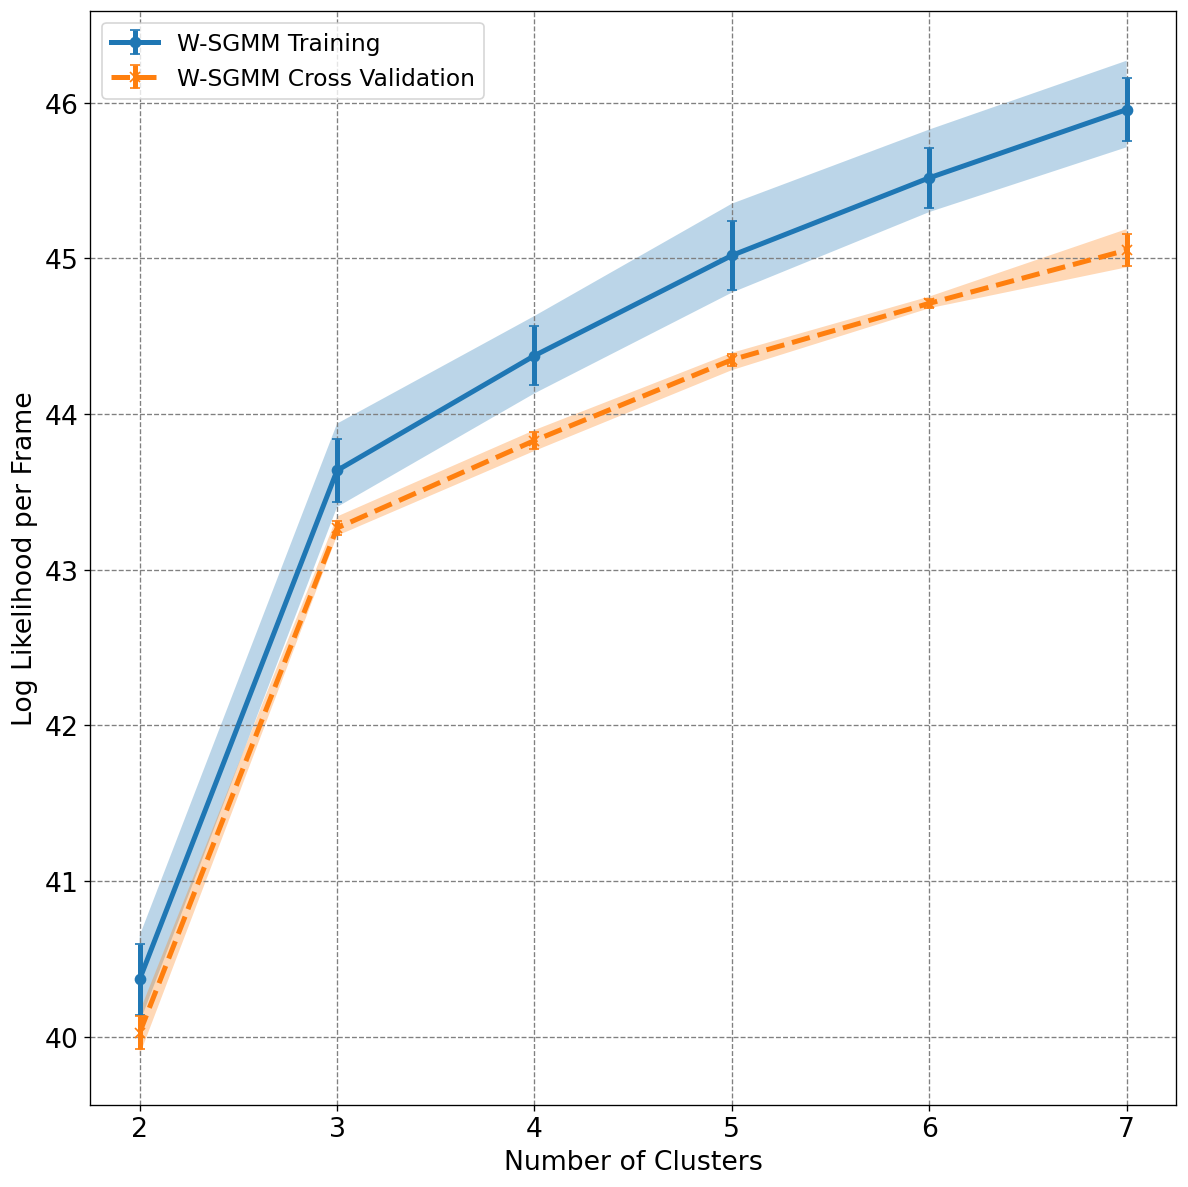

In [16]:
# create figure
plt.figure(figsize=(10,10), dpi= 120, facecolor='w', edgecolor='k')
# weighted SGMM
weighted_train_mean = np.mean(weighted_train_log_lik,axis=1)
weighted_train_std = np.std(weighted_train_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_train_mean,weighted_train_std,fmt='-o',lw=3,capsize=3,label="W-SGMM Training")
lower, upper = pyemma.util.statistics.confidence_interval((weighted_train_log_lik).T.tolist(), conf=0.9)
plt.fill_between(cluster_array, lower, upper, alpha=0.3)
weighted_predict_mean = np.mean(weighted_predict_log_lik,axis=1)
weighted_predict_std = np.std(weighted_predict_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_predict_mean,weighted_predict_std,fmt='--x',lw=3,capsize=3,label="W-SGMM Cross Validation")
lower, upper = pyemma.util.statistics.confidence_interval((weighted_predict_log_lik).T.tolist(), conf=0.9)
plt.fill_between(cluster_array, lower, upper, alpha=0.3)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Log Likelihood per Frame",fontsize=16)
plt.xlabel("Number of Clusters",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.savefig("beaded_helix_log_likelihood_cv.png",dpi=300,transparent=True)

## Run WSGMM for nClusters=3

In [17]:
n_clusters = 3
delta = 1
n_attempts = 5
objs = []
log_likes = []
for i in range(n_attempts):
    wsgmm = gmm_shapes.ShapeGMM(n_clusters,kabsch_thresh=1e-1,init_cluster_method='random',init_iter=5)
    wsgmm.fit_weighted(trajData[1::delta])
    print(i+1, wsgmm.log_likelihood/wsgmm.n_frames)
    objs.append(wsgmm)
    log_likes.append(wsgmm.log_likelihood)
# select obj with max log likelihood per frame
wsgmm = objs[np.argmax(log_likes)]

1 43.44848613652452
2 43.441591731473004
3 43.450697103330185
4 43.43069302322534
5 43.43569226984069


In [18]:
# reorder object
reorder_gmm_cluster_obj(wsgmm)

Number of clusters: 3
Populations prior to reorder: [0.4654 0.1456 0.389 ]
Populations after reorder: [0.4654 0.389  0.1456]


In [19]:
#predict if you didn't train on entire data set
entire_traj_clusters, entire_traj_traj, entire_traj_log_lik = wsgmm.predict_weighted(trajData[1:])

## Make 2D FE Plot with clusterings

In [20]:
from shapeGMM._traj_tools import weight_kabsch_dist_align

In [21]:
mahaClusterCenters = np.empty((trajData[1::delta].shape[0],2),dtype=np.float32)
for frame in range(trajData[1::delta].shape[0]):
    mahaClusterCenters[frame,0] = np.sqrt(weight_kabsch_dist_align(trajData[1::delta][frame],wsgmm.centers[0],wsgmm.precisions[0]))
    mahaClusterCenters[frame,1] = np.sqrt(weight_kabsch_dist_align(trajData[1::delta][frame],wsgmm.centers[1],wsgmm.precisions[1]))

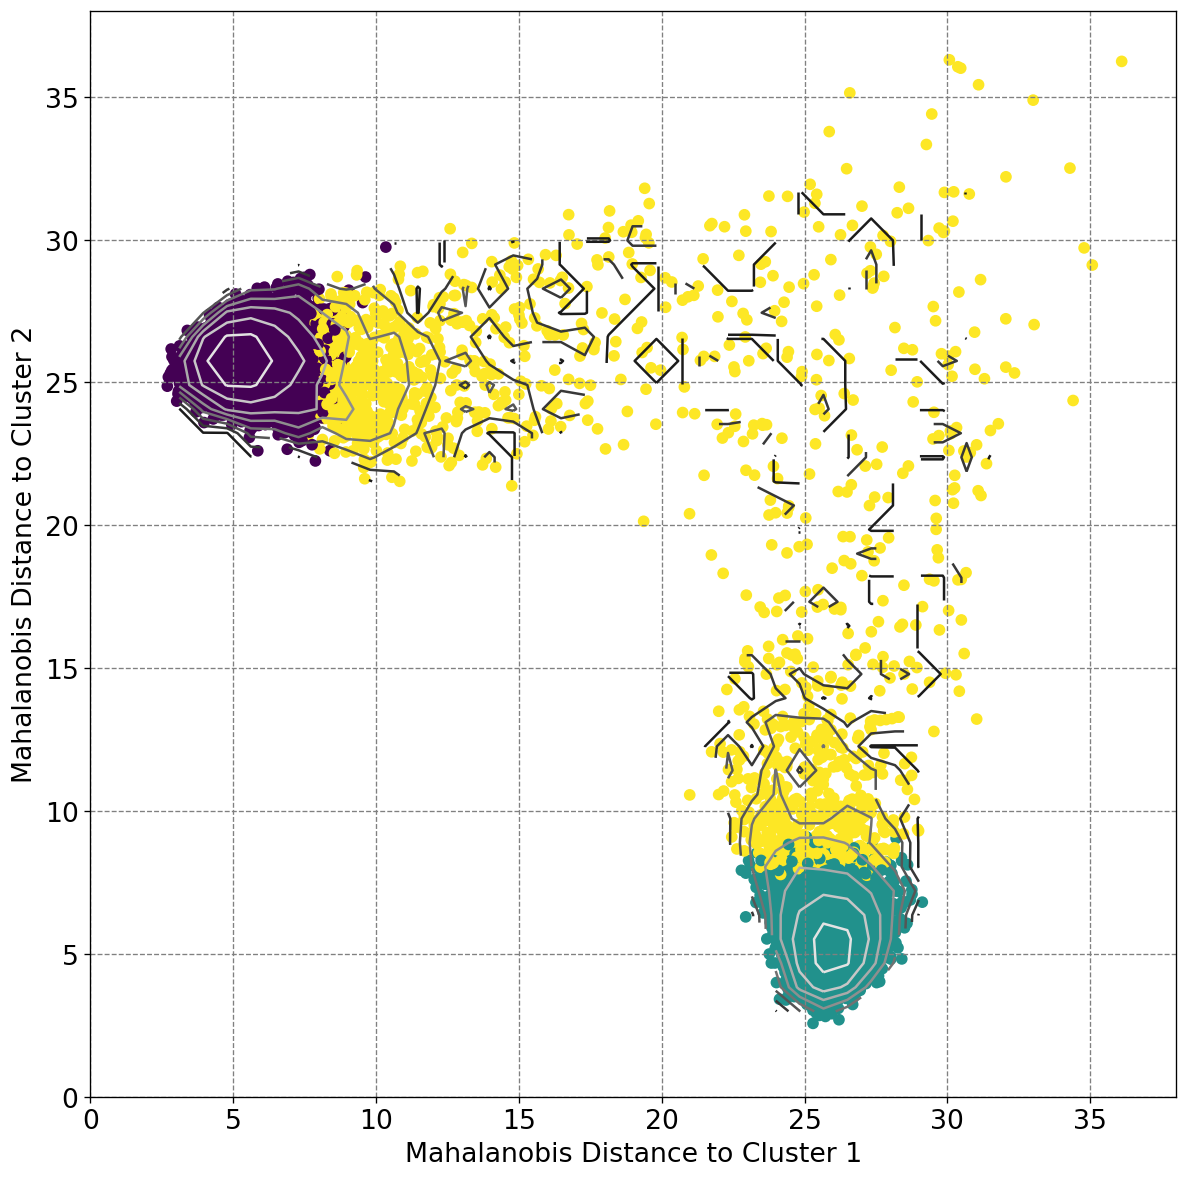

In [23]:
plt.figure(figsize=(10,10), dpi= 120, facecolor='w', edgecolor='k')
x = mahaClusterCenters[:,0]
y = mahaClusterCenters[:,1]
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
plt.contour(xx,yy,H,cmap='binary')
plt.ylabel("Mahalanobis Distance to Cluster 2",fontsize=16)
plt.xlabel("Mahalanobis Distance to Cluster 1",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.scatter(mahaClusterCenters[:,0],mahaClusterCenters[:,1],c=entire_traj_clusters)#,alpha=0.2)
plt.tight_layout()
plt.xlim(0,38)
plt.ylim(0,38)
plt.gca().set_aspect('equal')
#plt.savefig("beaded_helix_2D_FE_w_clusters.eps",dpi=300)